# Generate Faces using DCGAN

In [1]:
import os
from matplotlib import pyplot as plt
import time
import math

import mxnet as mx
from mxnet import gluon
from mxnet import ndarray as nd
from mxnet.gluon import nn, utils
from mxnet import autograd
import numpy as np
import pickle

In [2]:
def time_since(start):
    now = time.time()
    s = now - start
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


In [3]:
data_path = "/Users/dhoomilbsheta/Development/datasets/lfw-deepfunneled"

epochs = 10 # Set low by default for tests, set higher when you actually run this code.
batch_size = 64
latent_z_size = 100

use_gpu = False
ctx = mx.gpu() if use_gpu else mx.cpu()

lr = 0.0002
beta1 = 0.5
beta2 = 0.999

### Preprocess the LWF Face Dataset

In [ ]:
img_dims = 64
img_list = []

def transform(data, dims):
    data = mx.image.imresize(data, dims, dims)
    data = nd.transpose(data, (2,0,1))
    # normalize to [-1, 1]
    data = data.astype(np.float32)/127.5 - 1
    # if image is greyscale, repeat 3 times to get RGB image.
    if data.shape[0] == 1:
        data = nd.tile(data, (3, 1, 1))
    return data.reshape((1,) + data.shape)

for path, _, fnames in os.walk(data_path):
    for fname in fnames:
        if not fname.endswith('.jpg'):
            continue
        img = os.path.join(path, fname)
        img_arr = mx.image.imread(img)
        img_arr = transform(img_arr, img_dims)
        img_list.append(img_arr)
        
with open("faces_dataset_processed.pkl", "wb") as f:
    pickle.dump(img_list, f)

### Load Data

In [26]:
with open("faces_dataset_processed.pkl", "rb") as f:
    img_list = pickle.load(f)

In [27]:
train_data = mx.io.NDArrayIter(data=nd.concatenate(img_list[:2000]), batch_size=batch_size, shuffle=True)

In [28]:
train_data.num_data

2000

### Visualise some images

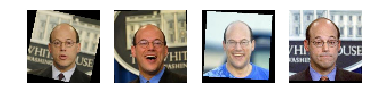

In [30]:
def visualize(img_arr):
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

for i in range(4):
    plt.subplot(1,4,i+1)
    visualize(img_list[i + 800][0])
plt.show()

## DCGAN Architecture
The core to the DCGAN architecture uses a standard CNN architecture on the discriminative model. For the generator, convolutions are replaced with upconvolutions, so the representation at each layer of the generator is actually successively larger, as it mapes from a low-dimensional latent vector onto a high-dimensional image.

1. Replace any pooling layers with strided convolutions (discriminator) and fractional-strided convolutions (generator).
2. Use batch normalization in both the generator and the discriminator.
3. Remove fully connected hidden layers for deeper architectures.
4. Use ReLU activation in generator for all layers except for the output, which uses Tanh.
5. Use LeakyReLU activation in the discriminator for all layers.


### Build the generator

In [31]:
class Generator(gluon.Block):
    def __init__(self, n_dims=64, **kwargs):
        super(Generator, self).__init__(**kwargs)
        self.n_dims = n_dims
        with self.name_scope():
            # layers created in name_scope will inherit name space
            # from parent layer.
            self.fc1 = nn.Dense(n_dims * 8 * 4 * 4)
            self.fc1_bnorm = nn.BatchNorm()
            self.fc1_act = nn.Activation('relu')

            self.deconv1 = nn.Conv2DTranspose(n_dims * 4, 4, 2, 1)
            self.deconv2 = nn.Conv2DTranspose(n_dims * 2, 4, 2, 1)
            self.deconv3 = nn.Conv2DTranspose(n_dims, 4, 2, 1)
            self.deconv4 = nn.Conv2DTranspose(3, 4, 2, 1)

            self.deconv1_bnorm = nn.BatchNorm()
            self.deconv2_bnorm = nn.BatchNorm()
            self.deconv3_bnorm = nn.BatchNorm()

            self.deconv1_relu = nn.Activation('relu')
            self.deconv2_relu = nn.Activation('relu')
            self.deconv3_relu = nn.Activation('relu')
            self.deconv4_tanh = nn.Activation('tanh')

    def forward(self, x, *args, **kwargs):
        x = self.fc1(x)
        x = mx.nd.reshape(x, shape=[-1, self.n_dims * 8, 4, 4])
        x = self.fc1_act(self.fc1_bnorm(x))
        x = self.deconv1_relu(self.deconv1_bnorm(self.deconv1(x)))
        x = self.deconv2_relu(self.deconv2_bnorm(self.deconv2(x)))
        x = self.deconv3_relu(self.deconv3_bnorm(self.deconv3(x)))
        x = self.deconv4_tanh((self.deconv4(x)))
        return x


### Build the discriminator

In [32]:
class Discriminator(gluon.Block):
    def __init__(self, n_dims=64, **kwargs):
        super(Discriminator, self).__init__(**kwargs)
        self.n_dims = n_dims
        with self.name_scope():
            self.conv1 = nn.Conv2D(n_dims, 4, 2, 1)
            self.conv2 = nn.Conv2D(n_dims * 2, 4, 2, 1)
            self.conv3 = nn.Conv2D(n_dims * 4, 4, 2, 1)
            self.conv4 = nn.Conv2D(n_dims * 8, 4, 2, 1)

            self.conv2_bnorm = nn.BatchNorm()
            self.conv3_bnorm = nn.BatchNorm()
            self.conv4_bnorm = nn.BatchNorm()

            self.conv1_lrelu = nn.LeakyReLU(0.2)
            self.conv2_lrelu = nn.LeakyReLU(0.2)
            self.conv3_lrelu = nn.LeakyReLU(0.2)
            self.conv4_lrelu = nn.LeakyReLU(0.2)
            self.flatten = nn.Flatten()
            self.fc = nn.Dense(1)

    def forward(self, x, *args, **kwargs):
        x = self.conv1_lrelu(self.conv1(x))
        x = self.conv2_lrelu(self.conv2_bnorm(self.conv2(x)))
        x = self.conv3_lrelu(self.conv3_bnorm(self.conv3(x)))
        x = self.conv4_lrelu(self.conv4_bnorm(self.conv4(x)))

        x = self.flatten(x)
        x = self.fc(x)
        return x


In [33]:
# loss
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

generator = Generator()
discriminator = Discriminator()
# initialize the generator and the discriminator
generator.initialize(mx.init.Normal(0.02), ctx=ctx)
discriminator.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(generator.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
trainerD = gluon.Trainer(discriminator.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})


### Training

In [34]:
real_label = nd.ones((batch_size,), ctx=ctx)
fake_label = nd.zeros((batch_size,),ctx=ctx)

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()

metric = mx.metric.CustomMetric(facc)
n_critic = 5 

In [35]:
errD_list = []
errG_list = []

In [36]:
def train(epochs):
    print(f"Training for {epochs} epochs...")
    start = time.time()
    for epoch in range(epochs):
        train_data.reset()
        iteration = 0
        for batch in train_data:
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            data = batch.data[0].as_in_context(ctx)
            latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size), ctx=ctx)

            with autograd.record():
                # train with real image
                output = discriminator(data).reshape((-1, 1))
                errD_real = loss(output, real_label)
                metric.update([real_label,], [output,])

                # train with fake image
                fake = generator(latent_z)
                output = discriminator(fake).reshape((-1, 1))
                errD_fake = loss(output, fake_label)
                errD = errD_real + errD_fake
                errD.backward()
                metric.update([fake_label,], [output,])

            trainerD.step(batch.data[0].shape[0])

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            with autograd.record():
                fake = generator(latent_z)
                output = discriminator(fake).reshape((-1, 1))
                errG = loss(output, real_label)
                errG.backward()

            trainerG.step(batch.data[0].shape[0])

            if iteration % 10 == 0:
                name, acc = metric.get()
                print(f'epoch {epoch}: iter {iteration} d_loss = {nd.mean(errD).asscalar()}, generator loss = {nd.mean(errG).asscalar()}, training acc = {acc}')

            iteration = iteration + 1
        print(f"Time: {time_since(start)}")
        name, acc = metric.get()
        metric.reset()
    print(f"Time: {time_since(start)}")

In [37]:
train(20)


Training for 20 epochs...
epoch 0: iter 0 d_loss = 1.5275522470474243, generator loss = 4.138174533843994, training acc = 0.5234375
epoch 0: iter 10 d_loss = 0.3841126263141632, generator loss = 9.935457229614258, training acc = 0.8849431818181818
epoch 0: iter 20 d_loss = 0.30775001645088196, generator loss = 12.557656288146973, training acc = 0.9226190476190477
epoch 0: iter 30 d_loss = 0.05041142553091049, generator loss = 5.3562703132629395, training acc = 0.9148185483870968
Time: 4m 9s
epoch 1: iter 0 d_loss = 0.10696201026439667, generator loss = 26.0562744140625, training acc = 0.96875
epoch 1: iter 10 d_loss = 0.4461621940135956, generator loss = 24.488365173339844, training acc = 0.8671875
epoch 1: iter 20 d_loss = 0.20297923684120178, generator loss = 8.8999605178833, training acc = 0.8839285714285714
epoch 1: iter 30 d_loss = 0.38116297125816345, generator loss = 9.854355812072754, training acc = 0.8833165322580645
Time: 8m 28s
epoch 2: iter 0 d_loss = 0.9315951466560364, ge

epoch 17: iter 20 d_loss = 0.45341169834136963, generator loss = 4.649755954742432, training acc = 0.8623511904761905
epoch 17: iter 30 d_loss = 0.37168434262275696, generator loss = 4.924542427062988, training acc = 0.8853326612903226
Time: 76m 33s
epoch 18: iter 0 d_loss = 0.31571510434150696, generator loss = 4.794572830200195, training acc = 0.96875
epoch 18: iter 10 d_loss = 0.30689549446105957, generator loss = 3.677079677581787, training acc = 0.921875
epoch 18: iter 20 d_loss = 0.25211578607559204, generator loss = 4.8704071044921875, training acc = 0.9263392857142857
epoch 18: iter 30 d_loss = 0.6039265990257263, generator loss = 6.277403831481934, training acc = 0.9075100806451613
Time: 80m 48s
epoch 19: iter 0 d_loss = 1.0263413190841675, generator loss = 8.41406536102295, training acc = 0.8203125
epoch 19: iter 10 d_loss = 0.26213571429252625, generator loss = 5.450167179107666, training acc = 0.8551136363636364
epoch 19: iter 20 d_loss = 0.29093924164772034, generator loss

In [42]:
def vis():
    
    num_image = 12
    latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size), ctx=ctx)
    step = 0.05
    for i in range(num_image):
        img = generator(latent_z)
        plt.subplot(3,4,i+1)
        visualize(img[0])
        latent_z += 0.05
    plt.show()

In [39]:
generator.save_params(filename="dcgan_g_faces")
discriminator.save_params(filename="dcgan_d_faces")

In [46]:
generator.load_params(filename="dcgan_g_faces", ctx=ctx)
discriminator.load_params(filename="dcgan_d_faces", ctx=ctx)
# train(10)

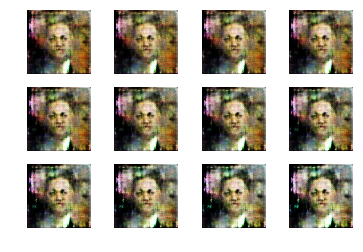

In [50]:
vis()

In [ ]:
train(20)